In [1]:
# Import the needed libraries
import pyodbc                                       # connection to the database (PyPI, 2019)
import pandas as pd                                 # pandas dataframes (www.w3schools.com, n.d.)
from pyspark.sql import SparkSession                # configuration of the spark session, pyspark sql queries, tables and miscellaneous commands (spark.apache.org, n.d.)
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.utils import *
from pyspark.ml.feature import VectorAssembler      # k means clustering, nearest neighbours and principal component analysis (Apache.org, 2019)
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.decomposition import PCA               # principal component analysis (scikit-learn.org, n.d.)
from sklearn.preprocessing import StandardScaler    # data scaling (Scikit-learn.org, 2019)
from sklearn.manifold import trustworthiness        # trustworthiness scores (scikit-learn.org, n.d.)
import math                                         # distances and formula (Python Software Foundation, n.d.)

In [2]:
# GET THE DATA FROM THE DATABASE AND SET UP THE DATAFRAMES

# Initialise a spark session
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()


# Create the connection and cursor (adapted from (Stack Overflow, n.d.))
conn = pyodbc.connect('DRIVER={ODBC Driver 18 for SQL Server};SERVER=anproject-sqlserver.database.windows.net;PORT=1433;DATABASE=anproject-sqldatabase;UID=anproject-sqlserver;PWD=zRd}gAPy/*Q625r(fSNTt&')
print(conn)
cursor = conn.cursor()


# Get each table into a dataframe
query = "SELECT * FROM Football.Club"           # Clubs, create the SQL query to retrieve the data
readsql = pd.read_sql(query, conn)              # read from the database
Club=spark.createDataFrame(readsql)             # create a dataframe from the return of the previous command

query = "SELECT * FROM Football.Dictionary"     # Event Dictionary, repeat for the rest of the tables in the database
readsql = pd.read_sql(query, conn)
Dictionary=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.Event"          # Events
readsql = pd.read_sql(query, conn)
Event=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.Lineup"         # Lineups
readsql = pd.read_sql(query, conn)
Lineup=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.Match"          # Matches
readsql = pd.read_sql(query, conn)
Match=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.Player"         # Players
readsql = pd.read_sql(query, conn)
Player=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.PlayerValue"    # Player market value history
readsql = pd.read_sql(query, conn)
PlayerValue=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.[Table]"        # Tables
readsql = pd.read_sql(query, conn)
Table=spark.createDataFrame(readsql)

query = "SELECT * FROM Football.Transfer"       # Transfers
readsql = pd.read_sql(query, conn)
Transfer=spark.createDataFrame(readsql)


# Close the connection
conn.close()

C:\Users\Alfie\AppData\Local\Temp\ipykernel_9584\1216373702.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  readsql = pd.read_sql(query, conn)              # read from the database
C:\Users\Alfie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
C:\Users\Alfie\AppData\Local\Temp\ipykernel_9584\1216373702.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider us

In [3]:
# SET THE VARIABLES NEEDED FOR FILTERING THE DATA

CurrentClub = "Leicester City"  # The club you are
Opponent = "Manchester United"  # Your opponent

CurrentClubID = 15  # Your club's ID
OpponentClubID = 19 # Your opponent's club's ID

SelectedResult = 5  # Which of the last five matches you would like to analyse

formation = [4, 4, 2] # state a formation [defenders, midfielders, attackers], to create the lineups later

TransferPlayer = "Islam Slimani" # Give the name of the player you are looking to replace
Budget = 20000000

In [4]:
# PROCESS THE ANALYTICS

# Collect the last 5 results against the opponent and show corresponding goal, shot and foul statistics
# Select the columns to be retrieved
Cols = ["Date", "HomeClubID", "AwayClubID","FullTimeHomeGoals", "FullTimeAwayGoals", "HalfTimeHomeGoals", "HalfTimeAwayGoals", "HomeShots", "AwayShots", "HomeShotsOnTarget", "AwaySHotsOnTarget", "HomeFouls", "AwayFouls", "HomeCorners", "AwayCorneras"]
# Select the home matches (where the home club ID is equal to your current club's ID, and the away club ID is equal to your opponent's ID)
HomeMatches = Match.select(Cols).filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).orderBy(desc("Date"))
# Select the away matches (where the hone club ID is equal to your opponent's club ID, and the home club ID is equal to your club ID)
AwayMatches = AllMatches = Match.select(Cols).filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).orderBy(desc("Date"))
# Union these two data frames to achieve all of the matches.
AllMatches = HomeMatches.union(AwayMatches).orderBy(desc("Date")).limit(5)


# Collect Lineups from previous matches between current club and opponent
# Select all the match dates from the union above (adapted from (spark.apache.org, n.d.))
Dates = AllMatches.select("Date").rdd.flatMap(lambda x: x).collect()
# Select all of the matches from the lineups dataframe where the date is in the list above
Lineups = Lineup.select("Date", "Type", "Number", "PlayerName", "Captain", "Position").filter(Lineup.Date.isin(Dates)).filter(Lineup.ClubID == CurrentClubID)


# Collect Opponent's last 5 matches
# Repeat the same as above, but with the opponent's last five matches, regardless of opponent
OpponentHomeMatches = Match.select(Cols).filter(Match.HomeClubID == OpponentClubID).orderBy(desc("Date"))
OpponentAwayMatches = Match.select(Cols).filter(Match.AwayClubID == OpponentClubID).orderBy(desc("Date"))
OpponentAllMatches = OpponentHomeMatches.union(OpponentAwayMatches).orderBy(desc("Date")).limit(5)


# Collect the lineups from the opponent's last 5 matches
OpponentDates = AllMatches.select("Date").rdd.flatMap(lambda x: x).collect()
OpponentLineups = Lineup.select("Date", "Type", "Number", "PlayerName", "Captain", "Position").filter(Lineup.Date.isin(OpponentDates)).filter(Lineup.ClubID == OpponentClubID)


# Collect Simple data about the opponent from club table
OpponentFacts = Club.select("*").filter(Club.ClubID == OpponentClubID)


# Fetch all of the events between current club and opponent club using IDs
# Select everything from the events table where the club ID is your club and the opponent club ID is the opponent club
EventsHome = Event.select("*").filter(Event.ClubID == CurrentClubID).filter(Event.OpponentClubID == OpponentClubID)
# repeat for away events with the IDs switched
EventsAway = Event.select("*").filter(Event.ClubID == OpponentClubID).filter(Event.OpponentClubID == CurrentClubID)


# Calculate numbers of each event types home vs away
# Fetch the current event type ID from the dictionary
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "EventType")
# group all of the events by the count of each event type
EventTypesHome = EventsHome.groupBy("EventType").count()
# join this with the dictionary to add the event type name
EventTypesHome = EventTypesHome.join(CurrentDictionary, EventTypesHome.EventType == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, EventTypesHome["count"]).withColumnRenamed("Explanation", "Event Type")
# repeat for away matches
EventTypesAway = EventsAway.groupBy("EventType").count()
EventTypesAway = EventTypesAway.join(CurrentDictionary, EventTypesAway.EventType == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, EventTypesAway["count"]).withColumnRenamed("Explanation", "Event Type")


# Repeat for all of the different event types that we want to compare
# Calculate number of each shot location
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "ShotLocation")
ShotLocationsHome = EventsHome.groupBy("ShotLocation").count()
ShotLocationsHome = ShotLocationsHome.join(CurrentDictionary, ShotLocationsHome.ShotLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, ShotLocationsHome["count"]).withColumnRenamed("Explanation", "Shot Location")
ShotLocationsAway = EventsAway.groupBy("ShotLocation").count()
ShotLocationsAway = ShotLocationsAway.join(CurrentDictionary, ShotLocationsAway.ShotLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, ShotLocationsAway["count"]).withColumnRenamed("Explanation", "Shot Location")

# Calculate the number of goals for each location
GoalLocationsHome = EventsHome.select("ShotLocation", "Goal").filter(EventsHome.Goal == 1).groupBy("ShotLocation").count()
GoalLocationsHome = GoalLocationsHome.join(CurrentDictionary, GoalLocationsHome.ShotLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, GoalLocationsHome["count"]).withColumnRenamed("Explanation", "Shot Location")
GoalLocationsAway = EventsAway.select("ShotLocation", "Goal").filter(EventsAway.Goal == 1).groupBy("ShotLocation").count()
GoalLocationsAway = GoalLocationsAway.join(CurrentDictionary, GoalLocationsAway.ShotLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, GoalLocationsAway["count"]).withColumnRenamed("Explanation", "Shot Location")

# Calculate number of shot pitch locations
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "Location")
ShotsHome = EventsHome.select("EventType", "PitchLocation").filter(EventsHome.EventType == 1).groupBy("PitchLocation").count()
ShotsHome = ShotsHome.join(CurrentDictionary, ShotsHome.PitchLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, ShotsHome["count"]).withColumnRenamed("Explanation", "Pitch Location")
ShotsAway = EventsAway.select("EventType", "PitchLocation").filter(EventsAway.EventType == 1).groupBy("PitchLocation").count()
ShotsAway = ShotsAway.join(CurrentDictionary, ShotsAway.PitchLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, ShotsAway["count"]).withColumnRenamed("Explanation", "Pitch Location")

# Calculate assist methods and what happened from each set piece types
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "AssistMethod")
AssistsHome = EventsHome.select("EventType", "AssistMethod").filter(EventsHome.EventType == 1).groupBy("AssistMethod").count()
AssistsHome = AssistsHome.join(CurrentDictionary, AssistsHome.AssistMethod == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, AssistsHome["count"]).withColumnRenamed("Explanation", "Assist Method")
AssistsAway = EventsAway.select("EventType", "AssistMethod").filter(EventsAway.EventType == 1).groupBy("AssistMethod").count()
AssistsAway = AssistsAway.join(CurrentDictionary, AssistsAway.AssistMethod == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, AssistsAway["count"]).withColumnRenamed("Explanation", "Assist Method")


# Collect opponent's favourite goal locations
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "ShotLocation")
OpponentFavouriteGoalLocation = EventsAway.select("ShotLocation", "Goal").filter(EventsAway.Goal == 1).groupBy("ShotLocation").count().orderBy("count", ascending = False)
OpponentFavouriteGoalLocation = OpponentFavouriteGoalLocation.join(CurrentDictionary, OpponentFavouriteGoalLocation.ShotLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, OpponentFavouriteGoalLocation["count"]).withColumnRenamed("Explanation", "Shot Location")
# Collect favourite assist method
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "AssistMethod")
OpponentFavouriteAssistMethod = EventsAway.select("EventType", "AssistMethod").filter(EventsAway.EventType == 1).groupBy("AssistMethod").count().orderBy("count", ascending = False)
OpponentFavouriteAssistMethod = OpponentFavouriteAssistMethod.join(CurrentDictionary, OpponentFavouriteAssistMethod.AssistMethod == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, OpponentFavouriteAssistMethod["count"]).withColumnRenamed("Explanation", "Assist Method")
# Collect favourite Pitch location
CurrentDictionary = Dictionary.select("*").filter(Dictionary.ColumnName == "Location")
OpponentFavouritePitchLocation = EventsAway.select("EventType", "PitchLocation").filter(EventsAway.EventType == 1).groupBy("PitchLocation").count().orderBy("count", ascending = False)
OpponentFavouritePitchLocation = OpponentFavouritePitchLocation.join(CurrentDictionary, OpponentFavouritePitchLocation.PitchLocation == CurrentDictionary.ID, "inner").select(CurrentDictionary.Explanation, OpponentFavouritePitchLocation["count"]).withColumnRenamed("Explanation", "Pitch Location")


# counter for caluclating thresholds between whether an insight should display or not
Counter = 0

# What statistics have high correlations to wins and losses?
    # Number of half time goals scored contributes to wins
    # Failing to stop high amounts of opponent shots leads to loss, and having more shots leads to wins
    # Large amount of shots on target leads to wins, more whilst home advantage
    # Large amount of set pieces means more wins and vice versa for opponents (free kicks also linked to number of fouls)
    # More events (set pieces, shots etc...) lead to less shots for an opponent
    # More goals leads to more wins (obviously, just worth mentioning)
    # Not just lack of shots, but more misses leads to less wins
# Display these stats between the host and opponent for selected result


# Half time goals and full time score
MatchDictionary = AllMatches.collect()[SelectedResult - 1].asDict()


# number of misses = number of shots - number of goals
# miss proportion = number of misses / number of shots
# expected goals = amount of shots / miss proportion
# create a proportion between the two by dividing them (collect function adapted from (GeeksforGeeks, 2021))
HomeShots = Match.select("HomeShots").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]
AwayShots = Match.select("AwayShots").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]

HomeGoals = Match.select("FullTimeHomeGoals").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]
AwayGoals = Match.select("FullTimeAwayGoals").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]

TotalShots = HomeShots + AwayShots
TotalGoals = HomeGoals + AwayGoals

HomeMisses = HomeShots - HomeGoals
AwayMisses = AwayShots - AwayGoals
HomeProportion = (HomeMisses / HomeShots) * 100
AwayProportion = (AwayMisses / AwayShots) * 100

AverageMissProportion = (HomeProportion + AwayProportion) / 2


# Calculate the number of set pieces and shots for club and opponent
HomeShotsSetPieces = EventsHome.select("EventType").filter(EventsHome.EventType.isin([1, 2])).count()
AwayShotsSetPieces = EventsAway.select("EventType").filter(EventsAway.EventType.isin([1, 2])).count()

Py4JJavaError: An error occurred while calling o289.javaToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 0.0 failed 1 times, most recent failure: Lost task 7.0 in stage 0.0 (TID 7) (DESKTOP-1GHK36R executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 38 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:320)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:187)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:296)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:179)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:173)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture$lzycompute(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture(ShuffleExchangeExec.scala:145)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.$anonfun$submitShuffleJob$1(ShuffleExchangeExec.scala:73)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob(ShuffleExchangeExec.scala:73)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob$(ShuffleExchangeExec.scala:72)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.submitShuffleJob(ShuffleExchangeExec.scala:120)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture$lzycompute(QueryStageExec.scala:187)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture(QueryStageExec.scala:187)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.doMaterialize(QueryStageExec.scala:189)
	at org.apache.spark.sql.execution.adaptive.QueryStageExec.materialize(QueryStageExec.scala:61)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5(AdaptiveSparkPlanExec.scala:286)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5$adapted(AdaptiveSparkPlanExec.scala:284)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:284)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:256)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:401)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.doExecute(AdaptiveSparkPlanExec.scala:386)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:195)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:191)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:207)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:206)
	at org.apache.spark.sql.Dataset.javaToPython(Dataset.scala:4151)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:701)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:745)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:698)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:663)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:639)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:585)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:543)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 38 more


Here are the last five matches between you and your opponent:


,Date,HomeClubID,AwayClubID,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwaySHotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorneras
0,2019-03-03,10,16,0,0,0,0,7,10,3,3,12,10,3,7
1,2018-12-02,16,10,1,0,0,0,16,9,3,3,12,7,8,1
2,2018-04-07,10,16,0,0,0,0,6,10,1,3,12,7,3,2
3,2017-12-10,16,10,1,1,1,0,23,3,3,2,8,11,12,1
4,2017-04-01,16,10,3,1,2,1,10,9,6,4,17,10,2,3


Here are your last 5 lineups between you and your opponent:


,Date,Type,Number,PlayerName,Captain,Position
0,2017-04-01,starting_lineup,7,James Milner,True,Left-Back
1,2017-04-01,substitutes,17,Ragnar Klavan,False,Centre-Back
2,2017-04-01,starting_lineup,6,Dejan Lovren,False,Centre-Back
3,2017-04-01,starting_lineup,21,Lucas Leiva,False,Defensive Midfield
4,2017-04-01,starting_lineup,5,Georginio Wijnaldum,False,Central Midfield
5,2017-04-01,starting_lineup,22,Simon Mignolet,False,Goalkeeper
6,2017-04-01,starting_lineup,10,Philippe Coutinho,False,Left Winger
7,2017-04-01,starting_lineup,32,Joel Matip,False,Centre-Back
8,2017-04-01,starting_lineup,2,Nathaniel Clyne,False,Right-Back
9,2017-04-01,substitutes,1,Loris Karius,False,Goalkeeper


Here are the last 5 matches your opponent has played:


,Date,HomeClubID,AwayClubID,FullTimeHomeGoals,FullTimeAwayGoals,HalfTimeHomeGoals,HalfTimeAwayGoals,HomeShots,AwayShots,HomeShotsOnTarget,AwaySHotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorneras
0,2019-05-03,10,6,2,0,2,0,20,5,6,1,8,9,8,1
1,2019-04-27,9,10,0,0,0,0,8,22,0,3,9,15,5,10
2,2019-04-21,10,19,4,0,2,0,15,7,8,1,11,7,10,2
3,2019-04-13,11,10,2,0,0,0,12,8,5,1,8,10,7,3
4,2019-04-07,10,1,1,0,1,0,23,7,6,2,8,9,9,6


Here are the lineups your opponent used in their last 5 matches:


,Date,Type,Number,PlayerName,Captain,Position
0,2017-04-01,substitutes,18,Gareth Barry,False,Defensive Midfield
1,2017-04-01,substitutes,22,Maarten Stekelenburg,False,Goalkeeper
2,2017-04-01,substitutes,9,Arouna Kon+-«,False,Centre-Forward
3,2017-04-01,starting_lineup,3,Leighton Baines,False,Left-Back
4,2017-04-01,starting_lineup,6,Phil Jagielka,True,Centre-Back
5,2017-04-01,substitutes,11,Kevin Mirallas,False,Second Striker
6,2017-04-01,starting_lineup,5,Ashley Williams,False,Centre-Back
7,2017-04-01,starting_lineup,10,Romelu Lukaku,False,Centre-Forward
8,2017-04-01,starting_lineup,1,Joel Robles,False,Goalkeeper
9,2017-04-01,starting_lineup,17,Idrissa Gueye,False,Defensive Midfield


,Position,count
0,Centre-Back,17
1,Right-Back,7
2,Attacking Midfield,5
3,Defensive Midfield,9
4,Right Winger,8
5,Centre-Forward,11
6,Second Striker,4
7,Goalkeeper,10
8,Left-Back,6
9,Central Midfield,8


Here are some useful facts about your opponent:


,ClubID,ClubName,SquadSize,AverageAge,NationalTeamPlayers,StadiumName,StadiumSeats,TransferRecord
0,10,Everton,25,27.0,6,Goodison Park,39571,42300000.0


Here is the amounts of each type of event that occured, home and then away:


,Event Type,count
0,Attempt,133
1,Corner,52
2,Substitution,18
3,Offside,12
4,Hand Ball,2
5,Foul,72
6,Free Kick Won,79
7,Yellow Card,11


,Event Type,count
0,Attempt,76
1,Corner,26
2,Substitution,20
3,Red Card,1
4,Offside,11
5,Hand Ball,1
6,Foul,79
7,Free Kick Won,74
8,Yellow Card,18


Here are the amount of shots your team has taken from each area of the pitch, home and then away:


,Shot Location,count
0,Bit Too High,2
1,Misses to the Right,10
2,Hits the Bar,4
3,Bottom Right Corner,13
4,Top Centre of the Goal,6
5,Bottom Left Corner,10
6,Blocked,39
7,Too High,12
8,High and Wide,7
9,Centre of the Goal,11


,Shot Location,count
0,Bit Too High,1
1,Misses to the Right,12
2,Bottom Right Corner,3
3,Top Centre of the Goal,5
4,Bottom Left Corner,6
5,Blocked,22
6,Too High,4
7,High and Wide,3
8,Centre of the Goal,7
9,Misses to the Left,6


Here are the amount of goals you have scored from each area of the pitch, home and then away:


,Shot Location,count
0,Bottom Right Corner,6
1,Bottom Left Corner,3
2,Centre of the Goal,1
3,Top Left Corner,2
4,Top Right Corner,2


,Shot Location,count
0,Bottom Right Corner,1
1,Centre of the Goal,1
2,Top Left Corner,1
3,Top Right Corner,2


Here is the total amount of shots your team has taken, home and then away:


,Pitch Location,count
0,Difficult Angle on the Left,2
1,Right Side of the Box,5
2,Centre of the Box,44
3,Left Side of the Six Yard Box,2
4,Very Close Range,5
5,Left Side of the Box,18
6,Right Side of the Siz Yard Box,3
7,Penalty Spot,1
8,Not Recorded,2
9,Outside the Box,51


,Pitch Location,count
0,Difficult Angle on the Right,1
1,Right Side of the Box,6
2,Centre of the Box,17
3,Left Side of the Six Yard Box,1
4,Very Close Range,1
5,Left Side of the Box,6
6,Right Side of the Siz Yard Box,1
7,More than 35 Yards,1
8,Outside the Box,41
9,Long Range,1


Here is the total amount of assists your team has made, home and then away:


,Assist Method,count
0,None,29
1,Pass,72
2,Headed Pass,1
3,Cross,24
4,Through Ball,7


,Assist Method,count
0,None,22
1,Pass,42
2,Headed Pass,1
3,Cross,7
4,Through Ball,4


Your opponent scores the most goals in this area of the goal:


,Shot Location
0,Bottom Right Corner


Your opponent's favourite assist method is:


,Assist Method
0,None


Your opponents favourite pitch location to score goals from is:


,Pitch Location
0,Difficult Angle on the Right



Here are the results at half and full time for the game you have chosen to analyze:
Result at half time - 0:0
Result at full time - 0:0

Here are the number of shots you and your opponent had in the match:
Club shots - 6
Opponent shots - 10

You had fewer shots than the opponent, this may have led to fewer goals. 


Here is the amount of shots on target you and your opponent had in that game:
Club shots on target - 1
Opponent shots on target - 3

You had fewer shots on target than the opponent, this may have led to fewer goals. 


Here is the number of set pieces you and your opponent had in the game:
Club set pieces - 10
Opponent set pieces - 14

You had fewer set pieces than the opponent, this may have led to fewer goals. 


The overall team's performance consisting of shots, set pieces and goals was poor. This leads to a higher chance of the opponent scoring more goals. 


Here is the proportion of shots that you and your opponent missed in that match:
Home miss proportion: 89.4179

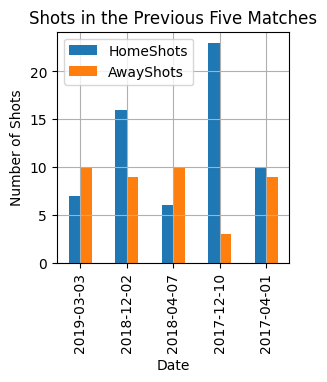

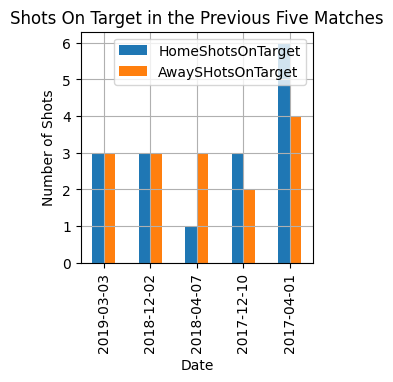

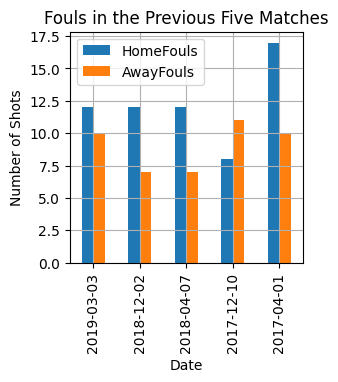

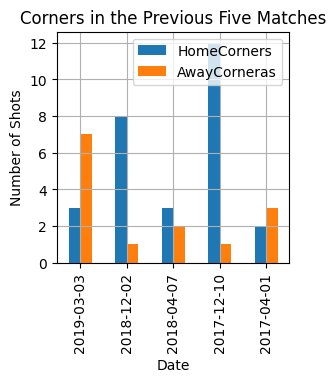

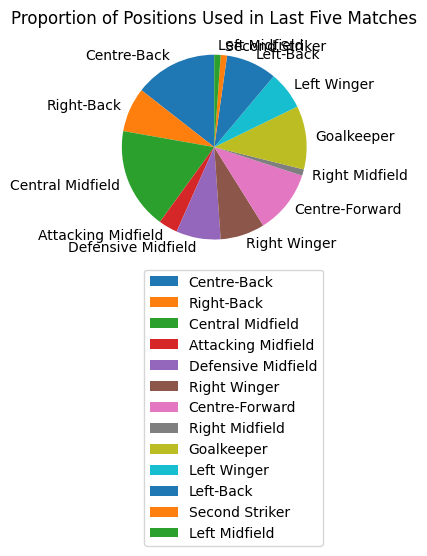

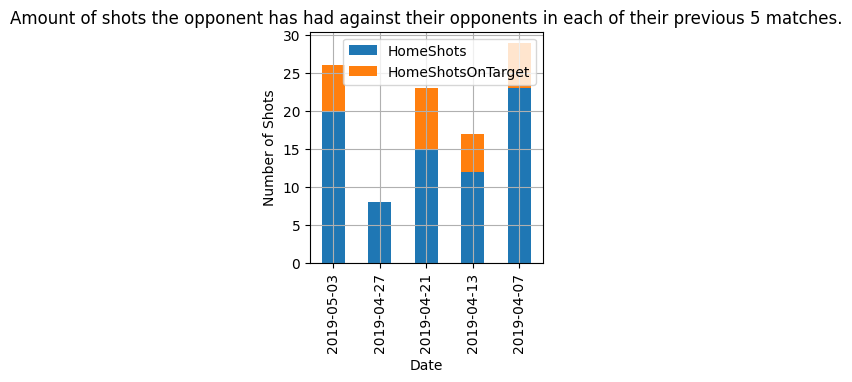

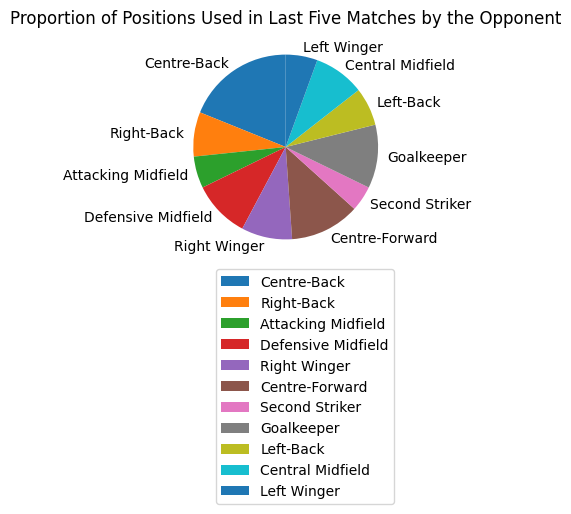

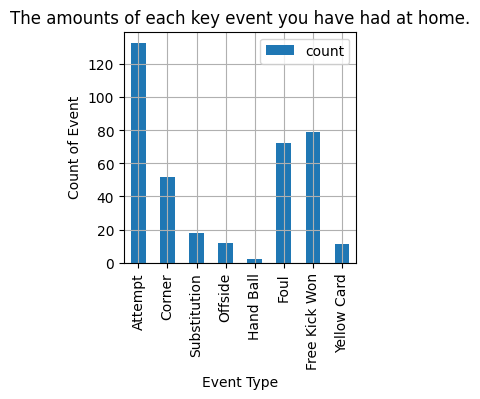

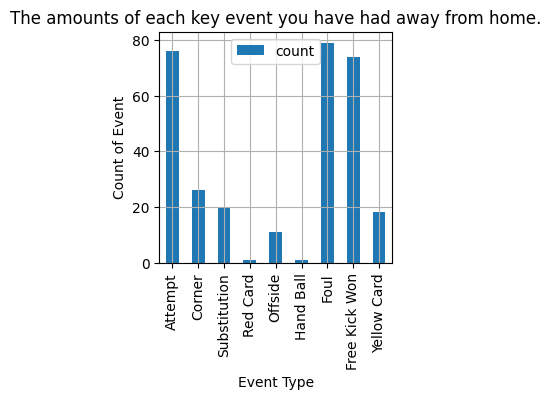

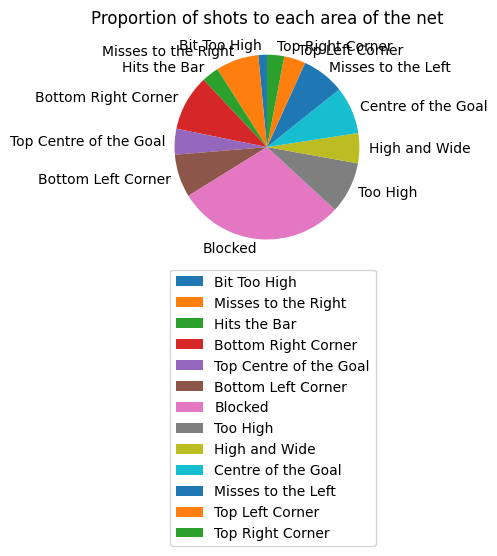

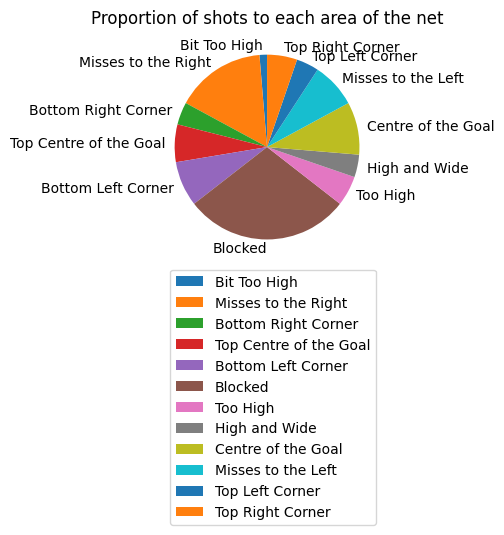

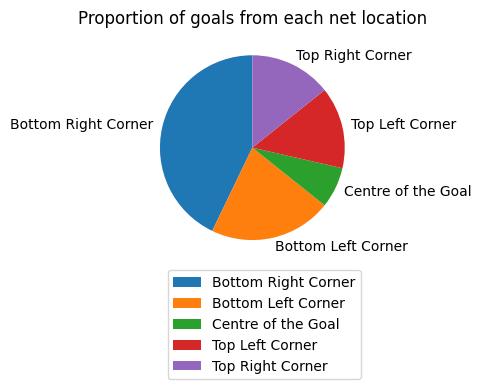

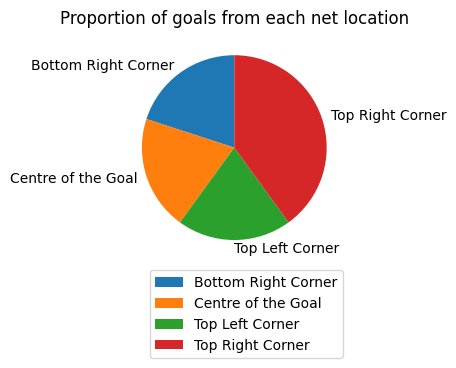

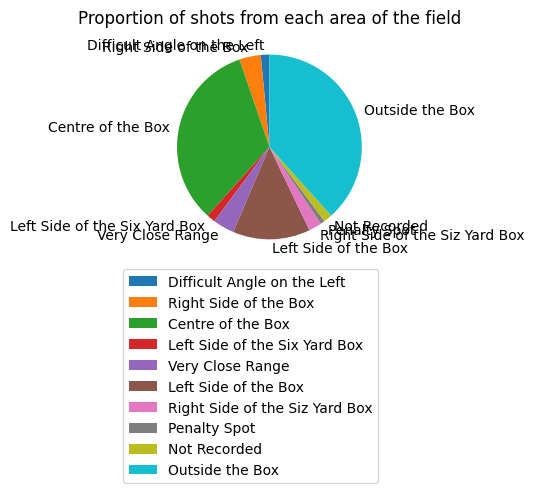

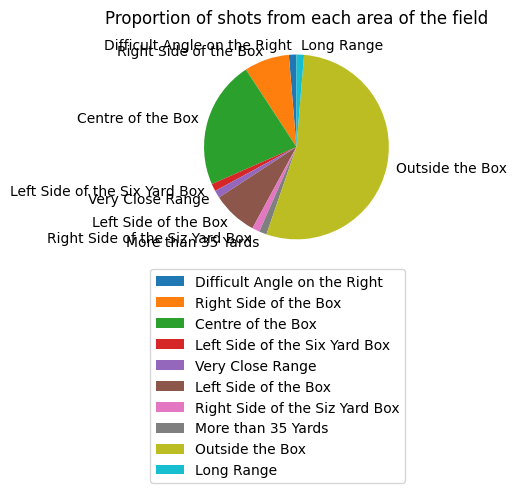

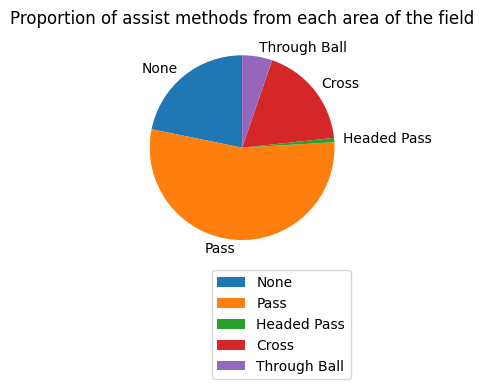

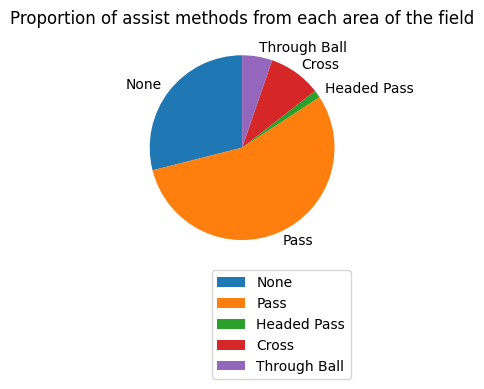

In [ ]:
################################################################
###### ANALYSIS DASHBOARD FOR DESCRIPTIVE AND DIAGNOSTIC #######
################################################################

pd.set_option('display.max_rows', 999)  # Do not truncate outputs (set_option learnt from (GeeksforGeeks, 2020))

# Everything under here just displays the information calculated above and creates some plots to go alongside

# Show the last 5 matches between the club and their opponent
# Print a message to make it look nicer
print("Here are the last five matches between you and your opponent:")
# convert the data frame to pandas to make plotting and displaying much more optimized
AllMatches = AllMatches.toPandas()
# display the information calculated
display(AllMatches)
# make the plot visualizations to see a deeper understanding of the data
plot = AllMatches.plot.bar(x = "Date", y = ["HomeShots", "AwayShots"], figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Number of Shots", title = "Shots in the Previous Five Matches")
plot = AllMatches.plot.bar(x = "Date", y = ["HomeShotsOnTarget", "AwaySHotsOnTarget"], figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Number of Shots", title = "Shots On Target in the Previous Five Matches")
plot = AllMatches.plot.bar(x = "Date", y = ["HomeFouls", "AwayFouls"], figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Number of Shots", title = "Fouls in the Previous Five Matches")
plot = AllMatches.plot.bar(x = "Date", y = ["HomeCorners", "AwayCorneras"], figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Number of Shots", title = "Corners in the Previous Five Matches")


# Repeat this process for each piece of information calculated above
# Show the last 5 lineups between the club and the opponent
print("Here are your last 5 lineups between you and your opponent:")
# Group the original dataframe to create even more insights
LineupsGB = Lineups.groupBy("Position").count()
Lineups = Lineups.toPandas()
display(Lineups)
LineupsGB = LineupsGB.toPandas()
plot = LineupsGB.plot.pie(labels = LineupsGB.Position, ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of Positions Used in Last Five Matches")
# Move the legend so that the graph is easily viewed
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Show the last 5 matches the opponent has played
print("Here are the last 5 matches your opponent has played:")
OpponentAllMatches = OpponentAllMatches.toPandas()
display(OpponentAllMatches)
plot = OpponentAllMatches.plot.bar(x = "Date", y = ["HomeShots", "HomeShotsOnTarget"], figsize = (3, 3), fontsize = 10, grid = True, stacked = True, ylabel = "Number of Shots", title = "Amount of shots the opponent has had against their opponents in each of their previous 5 matches.")


# Display the opponents last 5 lineups
print("Here are the lineups your opponent used in their last 5 matches:")
OpponentLineupsGB = OpponentLineups.groupBy("Position").count()
OpponentLineups = OpponentLineups.toPandas()
display(OpponentLineups)
OpponentLineupsGB = OpponentLineupsGB.toPandas()
display(OpponentLineupsGB)
plot = OpponentLineupsGB.plot.pie(labels = OpponentLineupsGB.Position, ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of Positions Used in Last Five Matches by the Opponent")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Display simple facts about the opponent
print("Here are some useful facts about your opponent:")
OpponentFacts = OpponentFacts.toPandas()
display(OpponentFacts)


# Show the amount of each event type
print("Here is the amounts of each type of event that occured, home and then away:")
EventTypesHome = EventTypesHome.toPandas()
display(EventTypesHome)
plot = EventTypesHome.plot.bar(x = "Event Type", y = "count", figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Count of Event", title = "The amounts of each key event you have had at home.")
EventTypesAway = EventTypesAway.toPandas()
display(EventTypesAway)
plot = EventTypesAway.plot.bar(x = "Event Type", y = "count", figsize = (3, 3), fontsize = 10, grid = True, ylabel = "Count of Event", title = "The amounts of each key event you have had away from home.")


# Display the amount of shots from each location on the pitch
print("Here are the amount of shots your team has taken from each area of the pitch, home and then away:")
ShotLocationsHome = ShotLocationsHome.toPandas()
display(ShotLocationsHome)
plot = ShotLocationsHome.plot.pie(labels = ShotLocationsHome["Shot Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of shots to each area of the net")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))
ShotLocationsAway = ShotLocationsAway.toPandas()
display(ShotLocationsAway)
plot = ShotLocationsAway.plot.pie(labels = ShotLocationsAway["Shot Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of shots to each area of the net")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Display the amount of goals that have been scored from each area of the pitch
print("Here are the amount of goals you have scored from each area of the pitch, home and then away:")
GoalLocationsHome = GoalLocationsHome.toPandas()
display(GoalLocationsHome)
plot = GoalLocationsHome.plot.pie(labels = GoalLocationsHome["Shot Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of goals from each net location")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))
GoalLocationsAway = GoalLocationsAway.toPandas()
display(GoalLocationsAway)
plot = GoalLocationsAway.plot.pie(labels = GoalLocationsAway["Shot Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of goals from each net location")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Display the total amount of shots
print("Here is the total amount of shots your team has taken, home and then away:")
ShotsHome = ShotsHome.toPandas()
display(ShotsHome)
plot = ShotsHome.plot.pie(labels = ShotsHome["Pitch Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of shots from each area of the field")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))
ShotsAway = ShotsAway.toPandas()
display(ShotsAway)
plot = ShotsAway.plot.pie(labels = ShotsAway["Pitch Location"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of shots from each area of the field")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Display the total amount of assists
print("Here is the total amount of assists your team has made, home and then away:")
AssistsHome = AssistsHome.toPandas()
display(AssistsHome)
plot = AssistsHome.plot.pie(labels = AssistsHome["Assist Method"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of assist methods from each area of the field")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))
AssistsAway = AssistsAway.toPandas()
display(AssistsAway)
plot = AssistsAway.plot.pie(labels = AssistsAway["Assist Method"], ylabel = "", y = "count", figsize = (10, 3), startangle = 90, fontsize = 10, title = "Proportion of assist methods from each area of the field")
plot.legend(loc = "best", bbox_to_anchor = (1, 0))


# Display the opponents favourite goal location
print("Your opponent scores the most goals in this area of the goal:")
# Limit the ordered dataframes to display "favourite" pieces of information
OpponentFavouriteGoalLocation = OpponentFavouriteGoalLocation.select("Shot Location").limit(1)
OpponentFavouriteGoalLocation = OpponentFavouriteGoalLocation.toPandas()
display(OpponentFavouriteGoalLocation)


# Display the opponents favourite assist method
print("Your opponent's favourite assist method is:")
OpponentFavouriteAssistMethod = OpponentFavouriteAssistMethod.select("Assist Method").limit(1)
OpponentFavouriteAssistMethod = OpponentFavouriteAssistMethod.toPandas()
display(OpponentFavouriteAssistMethod)


# Display the opponent's favourite goals pitch location
print("Your opponents favourite pitch location to score goals from is:")
OpponentFavouritePitchLocation = OpponentFavouritePitchLocation.select("Pitch Location").limit(1)
OpponentFavouritePitchLocation = OpponentFavouritePitchLocation.toPandas()
display(OpponentFavouritePitchLocation)


# Finally, print insights automatically given from the previous data (helps to reduce time with insights created automatically)
print("\n" + "Here are the results at half and full time for the game you have chosen to analyze:")
print("Result at half time - " + str(MatchDictionary.get("HalfTimeHomeGoals")) + ":" + str(MatchDictionary.get("HalfTimeAwayGoals")))
print("Result at full time - " + str(MatchDictionary.get("FullTimeHomeGoals")) + ":" + str(MatchDictionary.get("FullTimeAwayGoals")) + "\n")


# Explain why the result happened (loss because low amounts of shots in an area, win because of taller players used in certain positions?)
# Some will only display once a condition is met
if (MatchDictionary.get("HalfTimeHomeGoals") < MatchDictionary.get("HalfTimeAwayGoals") and MatchDictionary.get("FullTimeHomeGoals") < MatchDictionary.get("FullTimeAwayGoals")):
    print("You scored fewer goals than the opponent in the first half of the game. Fewer goals in the first half of a game may correlate to a loss. \n\n")
    Counter += 1


# Number of shots and opponents shots
print("Here are the number of shots you and your opponent had in the match:")
print("Club shots - " + str(MatchDictionary.get("HomeShots")))
print("Opponent shots - " + str(MatchDictionary.get("AwayShots")) + "\n")

if (MatchDictionary.get("HomeShots") < MatchDictionary.get("AwayShots")):
    print("You had fewer shots than the opponent, this may have led to fewer goals. \n\n")
    Counter += 1


# Shots on target
print("Here is the amount of shots on target you and your opponent had in that game:")
print("Club shots on target - " + str(MatchDictionary.get("HomeShotsOnTarget")))
print("Opponent shots on target - " + str(MatchDictionary.get("AwaySHotsOnTarget")) + "\n")

if (MatchDictionary.get("HomeShotsOnTarget") < MatchDictionary.get("AwaySHotsOnTarget")):
    print("You had fewer shots on target than the opponent, this may have led to fewer goals. \n\n")
    Counter += 1


# Set pieces
print("Here is the number of set pieces you and your opponent had in the game:")
print("Club set pieces - " + str(MatchDictionary.get("AwayFouls") + MatchDictionary.get("HomeCorners")))
print("Opponent set pieces - " + str(MatchDictionary.get("HomeFouls") + MatchDictionary.get("AwayCorneras")) + "\n")

if (MatchDictionary.get("AwayFouls") + MatchDictionary.get("HomeCorners") < MatchDictionary.get("HomeFouls") + MatchDictionary.get("AwayCorneras")):
    print("You had fewer set pieces than the opponent, this may have led to fewer goals. \n\n")
    Counter += 1


# Overall event performance
if (Counter >= 3):
    print("The overall team's performance consisting of shots, set pieces and goals was poor. This leads to a higher chance of the opponent scoring more goals. \n\n")


print("Here is the proportion of shots that you and your opponent missed in that match:")
print("Home miss proportion: " + str(HomeProportion))
print("Away miss proportion: " + str(AwayProportion) + "\n\n")

if (HomeProportion > AwayProportion):
    print("The team tend to miss more shots than the opponent, training to hit the target more often will increase the chances of goals, and reduce the number of chances the opoosition get to score.")


# if home has less, print that it leads to more chances for the opponent

print("Below is the number of shots and set pieces you and your opponent have had against each other:")
print("Home chances: " + str(HomeShotsSetPieces))
print("Away chances: " + str(AwayShotsSetPieces) + "\n")

if (HomeShotsSetPieces < AwayShotsSetPieces):
    print("The team tends to have fewer opportunities to score compared to the opponent. Creating fewer chances leaves more chances for the opoosition to score. \n\n")


In [ ]:
####################################################################
##### Data Processing for Predictive and Prescriptive Analysis #####
####################################################################


### Try to predict the outcome of the next match between the current club and opponent (expected goals for each side). ###

# Expected Goals = (s / m) / mp, where s = total number of shots, m = total number of matches, mp = miss proportion


# Select the total number of matches
HomeMatches = Match.select("HomeClubID").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID)
AwayMatches = Match.select("HomeClubID").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID)
NumberOfMatches = HomeMatches.union(AwayMatches).count()


# Divide the total number of average shots per match by the miss proportion we calculated before to get expected goals
AverageShotMatch = TotalShots / NumberOfMatches
OriginalExpectedGoals = AverageShotMatch / AverageMissProportion


# Repeat this for the opponent to get expected goals on both sides
OpponentHomeMatches = Match.select("HomeClubID").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID)
OpponentAwayMatches = Match.select("HomeClubID").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID)
OpponentNumberOfMatches = OpponentHomeMatches.union(OpponentAwayMatches).count()

OpponentHomeShots = Match.select("HomeShots").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]
OpponentAwayShots = Match.select("AwayShots").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]

OpponentHomeGoals = Match.select("FullTimeHomeGoals").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]
OpponentAwayGoals = Match.select("FullTimeAwayGoals").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]

OpponentTotalShots = OpponentHomeShots + OpponentAwayShots
OpponentTotalGoals = OpponentHomeGoals + OpponentAwayGoals

OpponentHomeMisses = OpponentHomeShots - OpponentHomeGoals
OpponentAwayMisses = OpponentAwayShots - OpponentAwayGoals
OpponentHomeProportion = (OpponentHomeMisses / OpponentHomeShots) * 100
OpponentAwayProportion = (OpponentAwayMisses / OpponentAwayShots) * 100

OpponentAverageMissProportion = (OpponentHomeProportion + OpponentAwayProportion) / 2


OpponentAverageShotMatch = OpponentTotalShots / OpponentNumberOfMatches
OpponentOriginalExpectedGoals = OpponentAverageShotMatch / OpponentHomeProportion


### Predict the opponent's lineup that they may use against you ###

# Collect Lineups from previous matches between current club and opponent, both home and away
HomeMatches = Match.select("*").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).orderBy(desc("Date"))
AwayMatches = Match.select("*").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).orderBy(desc("Date"))
AllMatches = HomeMatches.union(AwayMatches).orderBy(desc("Date")).limit(5)
Dates = AllMatches.select("Date").rdd.flatMap(lambda x: x).collect()
Lineups = Lineup.select("PlayerName", "Position").filter(Lineup.Date.isin(Dates)).filter(Lineup.ClubID == OpponentClubID)


# Get rid of any players who are no longer at the club and duplicate names from the lineups
Players = Lineups.join(Player, Lineups["PlayerName"] == Player["PlayerName"], "inner").select(Lineups["*"], Player.CurrentClubID).filter(Player.CurrentClubID == OpponentClubID).distinct()


# For each player, search through events between your team and the opponent's for instances of:
    # Forwards scoring
    # Midfielders creating chances / passing / assisting
    # Defenders stopping chances / causing misses
    # Goalkeepers saving


# Tell the program which subpositions correlate to overall positions
ForwardPositions = ["Centre-Forward", "Left Winger", "Right Winger", "Second Striker"]
MidfieldPositions = ["Attacking Midfield", "Central Midfield", "Defensive Midfield", "Left Midfield", "Right Midfield"]
DefensePositions = ["Centre-Back", "Left-Back", "Right-Back"]


# Create empty dictionaries for the players to go into
ForwardsDict = {}
MidfieldersDict = {}
DefendersDict = {}
GoalkeepersDict = {}


# Collect the players into a list
Forwards = Players.select("PlayerName").filter(Player.SubPosition.isin(ForwardPositions)).rdd.flatMap(lambda x: x).collect()
Midfielders = Players.select("PlayerName").filter(Player.SubPosition.isin(MidfieldPositions)).rdd.flatMap(lambda x: x).collect()
Defenders = Players.select("PlayerName").filter(Player.SubPosition.isin(DefensePositions)).rdd.flatMap(lambda x: x).collect()
Goalkeepers = Players.select("PlayerName").filter(Player.Position == "Goalkeeper").rdd.flatMap(lambda x: x).collect()


# for each player in forwards
# select all the events where they were playing against us and a shot occured
# count this
# add their name and this count to a forwards dictionary
for player in Forwards:
    ForwardsDict[player] = Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == OpponentClubID).filter(Event.OpponentClubID == CurrentClubID).filter(Event.EventType == 1).filter(Event.Goal == 1).union(Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == CurrentClubID).filter(Event.OpponentClubID == OpponentClubID).filter(Event.EventType == 1).filter(Event.Goal == 1)).count()
# repeat for each section of the pitch and respective event types
for player in Midfielders:
    MidfieldersDict[player] = Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == OpponentClubID).filter(Event.OpponentClubID == CurrentClubID).filter(Event.SecondaryEventType == 12).union(Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == CurrentClubID).filter(Event.OpponentClubID == OpponentClubID).filter(Event.SecondaryEventType == 12).filter(Event.Goal == 1)).count()

for player in Defenders:
    DefendersDict[player] = Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == OpponentClubID).filter(Event.OpponentClubID == CurrentClubID).filter(Event.ShotOutcome == 3).union(Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == CurrentClubID).filter(Event.OpponentClubID == OpponentClubID).filter(Event.ShotOutcome == 3).filter(Event.Goal == 1)).count()

for player in Goalkeepers:
    GoalkeepersDict[player] = Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == OpponentClubID).filter(Event.OpponentClubID == CurrentClubID).filter(Event.ShotOutcome == 3).union(Event.select("*").filter(Event.Player.like(player.lower())).filter(Event.ClubID == CurrentClubID).filter(Event.OpponentClubID == OpponentClubID).filter(Event.ShotOutcome == 3).filter(Event.Goal == 1)).count()


# sort the player dictionaries into most important players first, and select the number from the formation above (list sort function from (GeeksforGeeks, 2017))
ForwardsDict = dict(sorted(ForwardsDict.items(), key=lambda item: item[1], reverse = True)[:formation[2]])
MidfieldersDict = dict(sorted(MidfieldersDict.items(), key=lambda item: item[1], reverse = True)[:formation[1]])
DefendersDict = dict(sorted(DefendersDict.items(), key=lambda item: item[1], reverse = True)[:formation[0]])
GoalkeepersDict = dict(sorted(GoalkeepersDict.items(), key=lambda item: item[1], reverse = True)[:1])


# create empty lists for the players (will make it easier to display later)
ForwardsList = []
MidfieldersList = []
DefendersList = []
GoalkeepersList = []


# loop through each dictionary and add the player names to the lists
for key in ForwardsDict.keys():
    ForwardsList.append(key)

for key in MidfieldersDict.keys():
    MidfieldersList.append(key)

for key in DefendersDict.keys():
    DefendersList.append(key)

for key in GoalkeepersDict.keys():
    GoalkeepersList.append(key)


### Predict your finishing placement in the league ###

# P = (E(n, n-1)(p) * 2) where P = placement, n = number of clubs in the league, p = points
# Create the amount of points you would get from this

# Select all the clubs from last years table
ClubIDs = Table.select(Table.ClubID).filter(Table.Year == 2019).rdd.flatMap(lambda x: x).collect()
TotalPoints = 0

# Predict the results between you and every club in the league
    # Create a for loop that runs the excpected goal metrics on every club in the league
    # If our xG is larger = 3 points, if their xG is larger = 0 points, if xG within 0.5 of each other = 1 point
for ClubID in ClubIDs:
    # Calculate the home expected goals

    HomeMatches = Match.select("HomeClubID").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID)
    AwayMatches = Match.select("HomeClubID").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID)
    NumberOfMatches = HomeMatches.union(AwayMatches).count()

    HomeShots = Match.select("HomeShots").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]
    AwayShots = Match.select("AwayShots").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]

    HomeGoals = Match.select("FullTimeHomeGoals").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]
    AwayGoals = Match.select("FullTimeAwayGoals").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]

    TotalShots = HomeShots + AwayShots
    TotalGoals = HomeGoals + AwayGoals

    HomeMisses = HomeShots - HomeGoals
    AwayMisses = AwayShots - AwayGoals
    HomeProportion = (HomeMisses / HomeShots) * 100
    AwayProportion = (AwayMisses / AwayShots) * 100

    AverageShotMatch = TotalShots / NumberOfMatches
    AverageMissProportion = (HomeProportion + AwayProportion) / 2
    ExpectedGoals = AverageShotMatch / AverageMissProportion

    # calculate the opponents expected goals
    OpponentHomeMatches = Match.select("HomeClubID").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID)
    OpponentAwayMatches = Match.select("HomeClubID").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID)
    OpponentNumberOfMatches = OpponentHomeMatches.union(OpponentAwayMatches).count()

    OpponentHomeShots = Match.select("HomeShots").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]
    OpponentAwayShots = Match.select("AwayShots").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]

    OpponentHomeGoals = Match.select("FullTimeHomeGoals").filter(Match.HomeClubID == OpponentClubID).filter(Match.AwayClubID == CurrentClubID).groupBy().sum().collect()[0][0]
    OpponentAwayGoals = Match.select("FullTimeAwayGoals").filter(Match.HomeClubID == CurrentClubID).filter(Match.AwayClubID == OpponentClubID).groupBy().sum().collect()[0][0]

    OpponentTotalShots = OpponentHomeShots + OpponentAwayShots
    OpponentTotalGoals = OpponentHomeGoals + OpponentAwayGoals

    OpponentHomeMisses = OpponentHomeShots - OpponentHomeGoals
    OpponentAwayMisses = OpponentAwayShots - OpponentAwayGoals
    OpponentHomeProportion = (OpponentHomeMisses / OpponentHomeShots) * 100
    OpponentAwayProportion = (OpponentAwayMisses / OpponentAwayShots) * 100

    OpponentAverageMissProportion = (OpponentHomeProportion + OpponentAwayProportion) / 2


    OpponentAverageShotMatch = OpponentTotalShots / OpponentNumberOfMatches
    OpponentExpectedGoals = OpponentAverageShotMatch / OpponentHomeProportion

    # Compare the two expected goal metrics as described above
    if math.isclose(ExpectedGoals, OpponentExpectedGoals, abs_tol = 0.5) == True:
        TotalPoints += 1
    elif ExpectedGoals > OpponentExpectedGoals:
        TotalPoints += 3
    else:
        TotalPoints += 0


# Double them for home/away matches
TotalPoints *= 2


# Predict placement in league by 'placing' this amount of points with where it would be
# Filter the table with the your club removed
CurrentTable = Table.select("ClubID", "Points").filter(Table.Year == 2019).filter(Table.ClubID != CurrentClubID)
# create a data frame with one column in, your club and their predicted points
NewRow = spark.createDataFrame([(CurrentClubID, TotalPoints)], ["ClubID", "Points"])
# add it to the original table dataframe, ordered by points
AppendedRow = CurrentTable.union(NewRow).withColumn("Position", row_number().over(Window.orderBy(desc("Points"))))


### Predict the tactic to be used by the opponent ###


# Create a new dataframe with each club and there average amount of shots, key passes, events, blocks per game
HomeMatches = Match.select("HomeClubID").groupBy("HomeClubID").count().withColumnRenamed("count", "HomeMatches")
AwayMatches = Match.select("AwayClubID").groupBy("AwayClubID").count().withColumnRenamed("count", "AwayMatches")
TotalMatches = HomeMatches.join(AwayMatches, HomeMatches.HomeClubID == AwayMatches.AwayClubID, how = "inner").withColumn("TotalMatches", (col("HomeMatches") + col("AwayMatches")))


# Get Each total
TotalEvents = Event.select("ClubID").groupBy("ClubID").count().withColumnRenamed("count", "Events")
TotalShots = Event.select("ClubID").filter(Event.EventType == 1).groupBy("ClubID").count().withColumnRenamed("count", "TotalShots")
TotalKeyPasses = Event.select("ClubID").filter(Event.SecondaryEventType == 12).groupBy("ClubID").count().withColumnRenamed("count", "TotalKeyPasses")
TotalBlocks = Event.select("ClubID").filter(Event.ShotLocation == 2).groupBy("ClubID").count().withColumnRenamed("count", "TotalBlocks")


# Join each total finding average
TotalMatches = TotalMatches.join(TotalShots, TotalMatches.HomeClubID == TotalShots.ClubID, how = "inner").withColumn("AverageShotsPerMatch", (col("TotalShots") / col("TotalMatches")))
Features = TotalMatches.select("HomeClubID", "TotalMatches", "AverageShotsPerMatch")
Features = Features.join(TotalKeyPasses, Features.HomeClubID == TotalKeyPasses.ClubID, how = "inner").withColumn("AverageKeyPassesPerMatch", (col("TotalKeyPasses") / col("TotalMatches")))
Features = Features.join(TotalEvents, Features.HomeClubID == TotalEvents.ClubID, how = "inner").withColumn("AverageEventsPerMatch", (col("Events") / col("TotalMatches")))
Features = Features.join(TotalBlocks, Features.HomeClubID == TotalBlocks.ClubID, how = "inner").withColumn("AverageBlocksPerMatch", (col("TotalBlocks") / col("TotalMatches")))


# Select all the averages to use as features in the model
Features = Features.select("HomeClubID", "TotalMatches", "AverageShotsPerMatch", "AverageKeyPassesPerMatch", "AverageEventsPerMatch", "AverageBlocksPerMatch")


# Create an ML clustering model which gives each club their favourite tactic to use
# Select the features to be used
features = ["AverageShotsPerMatch", "AverageKeyPassesPerMatch", "AverageEventsPerMatch", "AverageBlocksPerMatch"]
# Create a vector assembler to transform the target and features
vectorAssembler = VectorAssembler(inputCols = features, outputCol = "FavouredTactic")
transformedData = vectorAssembler.transform(Features)


# describe the number of k means (number of different tactics)
k = 5


# fit the model and transform the data
kmeans = KMeans(featuresCol = "FavouredTactic", k=k, seed = 42)
model = kmeans.fit(transformedData)
predictions = model.transform(transformedData)
evaluator = ClusteringEvaluator(predictionCol = "prediction", featuresCol = "FavouredTactic")
silhouette_score_clubs = evaluator.evaluate(predictions)


# assign the text of the predictions instead of the given integers
FavouredTactic = predictions.select("HomeClubID", "prediction").withColumn("FavouredTactic", when(predictions.prediction == 0, "Long Ball") \
                                        .when(predictions.prediction == 1, "Wing Play") \
                                        .when(predictions.prediction == 2, "Balanced") \
                                        .when(predictions.prediction == 3, "Possesion") \
                                        .when(predictions.prediction == 4, "Tiki Taka")).withColumnRenamed("HomeClubID", "ClubID")


### Prescript the best tactic to use against the opponent ###


# For each match the opponent has played
OpponentHomeMatches = Match.select("HomeClubID", "AwayClubID", "Date").filter(Match.HomeClubID == OpponentClubID).filter(Match.FullTimeHomeGoals < Match.FullTimeAwayGoals)
OpponentAwayMatches = Match.select("HomeClubID", "AwayClubID", "Date").filter(Match.AwayClubID == OpponentClubID).filter(Match.FullTimeHomeGoals > Match.FullTimeAwayGoals)


# Count the number of losses against each tactic (basically saying we shall use the tactic that the opponent loses to the most)
OpponentHomeMatches = OpponentHomeMatches.join(FavouredTactic, OpponentHomeMatches.AwayClubID == FavouredTactic.ClubID, "inner").groupBy("FavouredTactic").count()
OpponentAwayMatches = OpponentAwayMatches.join(FavouredTactic, OpponentAwayMatches.HomeClubID == FavouredTactic.ClubID, "inner").groupBy("FavouredTactic").count()
OpponentLosses = OpponentHomeMatches.union(OpponentAwayMatches)
OpponentLosses = OpponentLosses.groupBy("FavouredTactic").sum("count").orderBy(desc("sum(count)")).limit(1)


### Prescribe the best lineup to use against an opponent ###


# Select all the players that are currently at the club (Name, position)
CurrentPlayers = Player.select("CurrentClubID", "PlayerName","SubPosition").filter(Player.CurrentClubID > 0).filter(Player.CurrentClubID < 36)


# Join the following information onto them:
    # Total number of shots
    # Total number of blocks
    # Total number of fouls
    # Total number of key passes
    # Total amount of events
    # Favourite shot location
    # Favourite assist method
CurrentPlayers = CurrentPlayers.select("CurrentClubID", "PlayerName", "SubPosition").join(Event, lower(CurrentPlayers.PlayerName) == Event.Player, "left").filter(Event.EventType == 1).groupBy("CurrentClubID", "PlayerName", "SubPosition").count().withColumnRenamed("count", "TotalShots")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").filter("b.ShotLocation == 2").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots").count().withColumnRenamed("count", "TotalBlocks")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").filter("b.EventType == 3").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots", "TotalBlocks").count().withColumnRenamed("count", "TotalFouls")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").filter("b.SecondaryEventType == 12").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots", "TotalBlocks", "TotalFouls").count().withColumnRenamed("count", "TotalKeyPasses")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").filter("b.ShotOutcome == 1").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots", "TotalBlocks", "TotalFouls", "TotalKeyPasses").agg(mode("ShotLocation")).withColumnRenamed("mode(ShotLocation)", "FavouriteShotLocation")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").filter("b.AssistMethod != 0").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots", "TotalBlocks", "TotalFouls", "TotalKeyPasses", "FavouriteShotLocation").agg(mode("AssistMethod")).withColumnRenamed("mode(AssistMethod)", "FavouriteAssistMethod")
CurrentPlayers = CurrentPlayers.alias("a").join(Event.alias("b"), lower(col("a.PlayerName")) == col("b.Player"), "left").groupBy("CurrentClubID", "PlayerName", "SubPosition", "TotalShots", "TotalBlocks", "TotalFouls", "TotalKeyPasses", "FavouriteShotLocation", "FavouriteAssistMethod").count().withColumnRenamed("count", "TotalEvents")


# Take all of the attackers, and cluster them, assigning the following labels:
    # Target man (high amount of shots, low amount of passes)
    # False 9 attacker (high amount of passes, low amount of shots, assist methods including passes and through balls)
    # Winger (high amount of passes, low amount of shots, assist methods including crosses)
# Assign players to positions depending on their sub position
Attackers = CurrentPlayers.filter(CurrentPlayers.SubPosition.isin("Centre-Forward", "Left Winger", "Right Winger", "Second Striker"))
Midfielders = CurrentPlayers.filter(CurrentPlayers.SubPosition.isin("Attacking Midfield", "Central Midfield", "Defensive Midfield", "Left Midfield", "Right Midfield"))
Defenders = CurrentPlayers.filter(CurrentPlayers.SubPosition.isin("Centre-Back", "Left-Back", "Right-Back"))
Goalkeepers = CurrentPlayers.filter(CurrentPlayers.SubPosition.isin("Goalkeeper"))

# Assign the features to be used for this position
features = ["TotalShots", "TotalKeyPasses"]
# Create the vector assembler (if no data, skip the player, avoids errors, adapted from (spark.apache.org, n.d.))
vectorAssembler = VectorAssembler(inputCols = features, outputCol = "PlayStyle", handleInvalid = "skip")
# transform the data
transformedData = vectorAssembler.transform(Attackers)


# create the number of k means (number of different types of that position)
k = 2

# fit the model and transform the data
kmeans = KMeans(featuresCol = "PlayStyle", k=k, seed = 42)
model = kmeans.fit(transformedData)
predictions = model.transform(transformedData)
evaluator = ClusteringEvaluator(predictionCol = "prediction", featuresCol = "PlayStyle")
silhouette_score_attackers = evaluator.evaluate(predictions)

# replace the predicted integer with the text playstyle
AttackersPlayStyle = predictions.select("CurrentClubID", "PlayerName", "prediction").withColumn("PlayStyle", when(predictions.prediction == 0, "Target Man") \
                                        .when(predictions.prediction == 1, "False Nine Attacker"))


# Repeat for midfielders
    # Box to box midfielder (high amount of key passes, low amount of blocks, high amount of events)
    # Defensive minded midfielder (high amount of blocks, low amount of shots and key passes)
    # Central minded midfielder (middle everything)
    # Attacking minded midfielder (high amount  of key passes, high amount of shots, low amount of blocks)
features = ["TotalShots", "TotalBlocks", "TotalEvents", "TotalKeyPasses"]
vectorAssembler = VectorAssembler(inputCols = features, outputCol = "PlayStyle", handleInvalid = "skip")
transformedData = vectorAssembler.transform(Midfielders)
k = 4
kmeans = KMeans(featuresCol = "PlayStyle", k=k, seed = 42)
model = kmeans.fit(transformedData)
predictions = model.transform(transformedData)
silhouette_score_midfielders = evaluator.evaluate(predictions)
MidfielderssPlayStyle = predictions.select("CurrentClubID", "PlayerName", "prediction").withColumn("PlayStyle", when(predictions.prediction == 0, "Box to Box Midfielder") \
                                        .when(predictions.prediction == 1, "Defensive Minded Midfielder") \
                                        .when(predictions.prediction == 2, "Central Minded Midfielder") \
                                        .when(predictions.prediction == 3, "Attacking Minded Midfielder"))


# Repeat for defenders
    # Wing back (high amount of passes, low amount of blocks)
    # Central minded defender (high amount of blocks, low amount of passes)
features = ["TotalBlocks", "TotalKeyPasses"]
vectorAssembler = VectorAssembler(inputCols = features, outputCol = "PlayStyle", handleInvalid = "skip")
transformedData = vectorAssembler.transform(Defenders)
k = 2
kmeans = KMeans(featuresCol = "PlayStyle", k=k, seed = 42)
model = kmeans.fit(transformedData)
predictions = model.transform(transformedData)
silhouette_score_defenders = evaluator.evaluate(predictions)
DefendersPlaystyle = predictions.select("CurrentClubID", "PlayerName", "prediction").withColumn("PlayStyle", when(predictions.prediction == 0, "Wing back") \
                                        .when(predictions.prediction == 1, "Central minded defender"))


# Repeat for goalkeepers
    # Sweeper keeper (high amount of blocks)
    # Reserved keeper (low amount of blocks)
features = ["TotalBlocks"]
vectorAssembler = VectorAssembler(inputCols = features, outputCol = "PlayStyle", handleInvalid = "skip")
transformedData = vectorAssembler.transform(Goalkeepers)
k = 2
kmeans = KMeans(featuresCol = "PlayStyle", k=k, seed = 42)
model = kmeans.fit(transformedData)
predictions = model.transform(transformedData)
silhouette_score_goalkeepers = evaluator.evaluate(predictions)
GoalkeepersPlaystyle = predictions.select("CurrentClubID", "PlayerName", "prediction").withColumn("PlayStyle", when(predictions.prediction == 0, "Sweeper Keeper") \
                                        .when(predictions.prediction == 1, "Reserved Keeper"))


# Assign suited tactics based on the preferred play style:
    # Tiki-taka: False nine attacker, box to box midfielder, target man
    # Long ball: wing back, reserved keeper
    # Wing play: wingers
    # Possession: defensive minded midfielder, sweeper keeper
    # Balanced: attacking minded midfielder, central minded defender, central minded midfielder
# Union all the created data frames together
PlayersWithPlayStyle = AttackersPlayStyle.union(MidfielderssPlayStyle)
PlayersWithPlayStyle = PlayersWithPlayStyle.union(DefendersPlaystyle)
PlayersWithPlayStyle = PlayersWithPlayStyle.union(GoalkeepersPlaystyle)


# Create a new column and assign each player a preferred tactic depending on their playstyle
PlayersWithPlayStyle = PlayersWithPlayStyle.select("*").withColumn("PreferredTactic", when(PlayersWithPlayStyle.PlayStyle.isin("False Nine Attacker", "Box to Box Midfielder", "Target Man"), "Tiki Taka") \
                                                                   .when(PlayersWithPlayStyle.PlayStyle.isin("Wing back", "Reserved Keeper"), "Long Ball") \
                                                                   .when(PlayersWithPlayStyle.PlayStyle.isin("Wingers"), "Wing Play") \
                                                                   .when(PlayersWithPlayStyle.PlayStyle.isin("Defensive Minded Midfielder", "Sweeper Keeper"), "Possession") \
                                                                   .when(PlayersWithPlayStyle.PlayStyle.isin("Attacking Minded Midfielder", "Central minded defender", "Central Minded Midfielder"), "Balanced"))


# Select the players with the preferred tactics based on opponent's predicted tactics
    # Opponent's Tactic: Prescribed players tactic
    # Tiki-taka -> Possession, balanced, wing play
    # Long Ball -> balanced, wing play
    # Wing play -> Tiki taka, balanced
    # Possession -> Long ball, tiki-taka, balanced, 
    # Balanced -> Everything
OpponentTactic = FavouredTactic.select("ClubID", "FavouredTactic").filter(FavouredTactic.ClubID == OpponentClubID).collect()[0][0]


# Pick the players that are most suited to playing against an opponent's tactic, depending on their preferred playstyle and tactic
if (OpponentTactic == "Tiki-Taka"):
    PlayersWithPlayStyle = PlayersWithPlayStyle.select("PlayerName").filter(PlayersWithPlayStyle.CurrentClubID == CurrentClubID).filter(PlayersWithPlayStyle.PreferredTactic.isin("Tiki Taka", "Balanced", "Wing Play"))
elif (OpponentTactic == "Long Ball"):
    PlayersWithPlayStyle = PlayersWithPlayStyle.select("PlayerName").filter(PlayersWithPlayStyle.CurrentClubID == CurrentClubID).filter(PlayersWithPlayStyle.PreferredTactic.isin("Balanced", "Wing Play"))
elif (OpponentTactic == "Wing Play"):
    PlayersWithPlayStyle = PlayersWithPlayStyle.select("PlayerName").filter(PlayersWithPlayStyle.CurrentClubID == CurrentClubID).filter(PlayersWithPlayStyle.PreferredTactic.isin("Tiki Taka", "Balanced"))
elif (OpponentTactic == "Possession"):
    PlayersWithPlayStyle = PlayersWithPlayStyle.select("PlayerName").filter(PlayersWithPlayStyle.CurrentClubID == CurrentClubID).filter(PlayersWithPlayStyle.PreferredTactic.isin("Long Ball", "Tiki Taka", "Balanced"))
else:
    PlayersWithPlayStyle = PlayersWithPlayStyle.select("PlayerName").filter(PlayersWithPlayStyle.CurrentClubID == CurrentClubID)


### Advisory for future transfers ###

# Create a table with a list of players and a bunch of their attributes
    # PlayerName, CurrentClubID, BirthCountry, BirthDate, SubPosition, PreferredFoot, Height, MarketValue, BenchProportion, TotalShots, TotalPasses, TotalBlocks
# Going to have to join table after table here, not really an easier way unfortunately
# Amount of player benches
PlayerBenches = Player.select("PlayerName", "CurrentClubID", "BirthCountry", "BirthDate", "SubPosition", "PreferredFoot", "Height", "MarketValue")
PlayerBenches = PlayerBenches.join(Lineup, PlayerBenches.PlayerName == Lineup.PlayerName, how = "inner").filter(Lineup.Type == "substitutes").groupBy(PlayerBenches["PlayerName"]).count().withColumnRenamed("count", "Benches")
# Amount of games
PlayerGames = Player.select("PlayerName", "CurrentClubID", "BirthCountry", "BirthDate", "SubPosition", "PreferredFoot", "Height", "MarketValue")
PlayerGames = PlayerGames.join(Lineup, PlayerGames.PlayerName == Lineup.PlayerName, how = "inner").groupBy(PlayerGames["PlayerName"]).count().withColumnRenamed("count", "Games")
# Create proportions of games played and bench proportion
PlayerRecommender = PlayerGames.join(PlayerBenches, PlayerGames.PlayerName == PlayerBenches.PlayerName, how = "inner").drop(PlayerBenches.PlayerName)
PlayerRecommender = PlayerRecommender.withColumn("BenchProportion", PlayerRecommender.Benches / PlayerRecommender.Games * 100)
# Total player shots
PlayerTotalShots = Event.select("Player").filter(Event.EventType == 1).groupBy("Player").count().withColumnRenamed("count", "TotalShots")
PlayerRecommender = PlayerRecommender.join(PlayerTotalShots, lower(PlayerRecommender.PlayerName) == PlayerTotalShots.Player, how = "inner")
PlayerRecommender = PlayerRecommender.drop("Player")
# Total key passes
PlayerTotalKeyPasses = Event.select("Player").filter(Event.SecondaryEventType == 12).groupBy("Player").count().withColumnRenamed("count", "TotalKeyPasses")
PlayerRecommender = PlayerRecommender.join(PlayerTotalKeyPasses, lower(PlayerRecommender.PlayerName) == PlayerTotalKeyPasses.Player, how = "inner")
PlayerRecommender = PlayerRecommender.drop("Player")
# Total blocks
PlayerTotalBlocks = Event.select("Player").filter(Event.ShotLocation == 2).groupBy("Player").count().withColumnRenamed("count", "TotalBlocks")
PlayerRecommender = PlayerRecommender.join(PlayerTotalBlocks, lower(PlayerRecommender.PlayerName) == PlayerTotalBlocks.Player, how = "inner")
PlayerRecommender = PlayerRecommender.drop("Player")


# Drop any uneeded columns
PlayerRecommender = PlayerRecommender.alias("a").join(Player.alias("b"), col("a.PlayerName") == col("b.PlayerName"), how = "inner").drop(col("b.PlayerName"))
PlayerRecommender = PlayerRecommender.drop("Games", "Benches", "PlayerID", "Citizenship", "Position", "RecordMarketValue", "ContractExpiration", "AgentName")


# Convert to pandas to make displaying and processing quicker, and drop rows with missing values (avoids errors in PCA)
PlayerRecommender = PlayerRecommender.toPandas()
PlayerRecommender = PlayerRecommender.dropna()


# Create a recommender engine to suggest similar players based on a position or other player's features
# Select the features
features = ["Height", "MarketValue", "BenchProportion", "TotalShots", "TotalKeyPasses", "TotalBlocks"]


# Select the data and targets
data = PlayerRecommender.loc[:, features].values
target = PlayerRecommender.loc[:, ["PlayerName"]].values


# Transform and fit the model
data = StandardScaler().fit_transform(data)


# Select the amount of features to reduce to, fit and transform the model once again
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
trustworthiness = trustworthiness(data, principalComponents, n_neighbors=5)


# create a data frame from the model to plot players
principalDf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, PlayerRecommender[['PlayerName']]], axis = 1)
finalDf = finalDf.dropna()
finalDf = spark.createDataFrame(finalDf)


# Get their positions on the graph
TransferPlayerPosition = Player.select("Position").filter(Player.PlayerName == TransferPlayer).collect()[0][0]
TransferPlayerX = finalDf.filter(finalDf.PlayerName == TransferPlayer).select("principal component 1").collect()[0][0]
TransferPlayerY = finalDf.filter(finalDf.PlayerName == TransferPlayer).select("principal component 2").collect()[0][0]


# create a new column in the original dataframe, where the new column is the euclidean distance from the selected player on the graph (maps a similarity score), adapted from (Wikipedia Contributors, 2019)
finalDf = finalDf.withColumn(colName = "DistanceToPlayer", col = sqrt(pow((TransferPlayerX - finalDf["principal component 1"]), 2) + pow((TransferPlayerY - finalDf["principal component 2"]), 2)))


# Show their names and other information
finalDf = finalDf.select("PlayerName")
finalDf = finalDf.join(Player, Player.PlayerName == finalDf.PlayerName, how = "inner")
finalDf = finalDf.drop("CurrentClubID", "MarketValue")
finalDf = finalDf.join(PlayerValue, PlayerValue.PlayerID == finalDf.PlayerID, how = "inner")
finalDf = finalDf.dropDuplicates(["PlayerName"])


# Get rid of any players that are currently at the club, and do not play in the transferplayers position, that are below budget, and did not retire before 2017 (year matches when the data is from)
finalDf = finalDf.filter(finalDf.CurrentClubID != CurrentClubID).filter(finalDf.Position == TransferPlayerPosition).filter(finalDf.MarketValue <= Budget).filter(finalDf.LastSeason >= 2017)

C:\Users\newto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [ ]:
######################################################
### Predictive and Prescriptive Analysis Dashboard ###
######################################################

# Same as above, print insights, statistics and plots about the information above


# Expected goals for next match
print("Your opponent's expected goals for your next match is: " + str(OpponentOriginalExpectedGoals))
print("Your expected goals for your next match against your opponent is: " + str(OriginalExpectedGoals) + "\n\n")


# What players the opponent is most likely to use
print("Here are the players your opponent is most likely to use in their next match: \n")
print(str(ForwardsList))
print(str(MidfieldersList))
print(str(DefendersList))
print(str(GoalkeepersList) + "\n")


# Predicted placement in the league next season
print("Here is where you are most likely to finish next season:")
AppendedRow = AppendedRow.select("position").filter(AppendedRow.ClubID == CurrentClubID)
AppendedRow = AppendedRow.toPandas()
display(AppendedRow)


# Tactic most likely to be used by your opponent
print("The tactic most likely to be used by your opponent is:")
FavouredTactic = FavouredTactic.select("ClubID", "FavouredTactic").filter(FavouredTactic.ClubID == OpponentClubID)
FavouredTactic = FavouredTactic.toPandas()
display(FavouredTactic)
FavouredTactic = spark.createDataFrame(FavouredTactic)


# Suggest your team use the tactic that causes the most losses against the opponent
print("The best tactic to use against your opponent would be: \n")
OpponentLosses = OpponentLosses.select("FavouredTactic")
OpponentLosses = OpponentLosses.toPandas()
display(OpponentLosses)


# Present this list of players as the 'first choice' for a lineup against the opponent
print("Here is a list of players you should prioritise in the lineup to produce the best result against your opponent, based on the players preferred tactics:")
PlayersWithPlayStyle = PlayersWithPlayStyle.toPandas()
display(PlayersWithPlayStyle)


# display the top 3 best transfer replacements
finalDf = finalDf.toPandas()
finalDf = finalDf.head(3)
print(finalDf)


# display evaluation metrics for the machine learning models
print("Here are the evaluation metrics for the machine learning models:")
print("Tactics Clustering:")
print("Silhouette score: " + str(silhouette_score_clubs))
print("Player Clustering:")
print("Attackers silhouette score: " + str(silhouette_score_attackers))
print("Midfielders silhouette score: " + str(silhouette_score_midfielders))
print("Defenders silhouette score: " + str(silhouette_score_defenders))
print("Goalkeepers silhouette score: " + str(silhouette_score_goalkeepers))
print("Transfer PCA:")
print("Trustworthiness: " + str(trustworthiness))

Your opponent's expected goals for your next match is: 0.10375757575757576
Your expected goals for your next match against your opponent is: 0.1728772255988559


Here are the players your opponent is most likely to use in their next match: 

['Dominic Calvert-Lewin', 'Oumar Niasse']
['Idrissa Gueye', 'Gylfi Sigurdsson']
['Leighton Baines', 'Ashley Williams', 'Matthew Pennington', 'Michael Keane']
['Jordan Pickford']

Here is where you are most likely to finish next season:


,position
0,15


The tactic most likely to be used by your opponent is:


,ClubID,FavouredTactic
0,10,Tiki Taka


C:\Users\newto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyspark\sql\pandas\conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


The best tactic to use against your opponent would be: 



,FavouredTactic
0,Long Ball


Here is a list of players you should prioritise in the lineup to produce the best result against your opponent, based on the players preferred tactics:


,PlayerName
0,Mohamed Salah
1,Roberto Firmino
2,Steven Gerrard
3,Kevin Stewart
4,Paulinho
5,Andrew Robertson
6,Virgil van Dijk
7,Andre Wisdom
8,Joel Matip


     PlayerName  PlayerID    PlayerName BirthCountry   BirthCity Citizenship  \
0  Aaron Ramsey    646658  Aaron Ramsey      England  Birmingham     England   
1  Adam Forshaw    121257  Adam Forshaw      England   Liverpool     England   
2    Alex Iwobi    242631    Alex Iwobi      Nigeria       Lagos     Nigeria   

    BirthDate  Position         SubPosition PreferredFoot  Height  \
0  2003-01-21  Midfield  Attacking Midfield         right   181.0   
1  1991-10-08  Midfield    Central Midfield         right   175.0   
2  1996-05-03  Midfield  Attacking Midfield         right   183.0   

   RecordMarketValue ContractExpiration            AgentName  PlayerID  \
0         15000000.0         2028-06-30  Unique Sports Group    646658   
1          5000000.0               None            Wasserman    121257   
2         32000000.0         2028-06-30                 None    242631   

   CurrentClubID  LastSeason  MarketValue  
0           1132        2023    3000000.0  
1            399 

In [ ]:
### REFERENCES ###

# PyPI. (2019). pyodbc. [online] Available at: https://pypi.org/project/pyodbc/.
# www.w3schools.com. (n.d.). Pandas DataFrames. [online] Available at: https://www.w3schools.com/python/pandas/pandas_dataframes.asp.
# spark.apache.org. (n.d.). Spark SQL — PySpark 3.5.0 documentation. [online] Available at: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/index.html.
# Apache.org. (2019). MLlib: Main Guide - Spark 2.4.4 Documentation. [online] Available at: https://spark.apache.org/docs/latest/ml-guide.html.
# scikit-learn.org. (n.d.). API Reference — scikit-learn 0.22.2 documentation. [online] Available at: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition.
# Scikit-learn.org. (2019). 5.3. Preprocessing data — scikit-learn 0.21.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/preprocessing.html.
# scikit-learn.org. (n.d.). 2.2. Manifold learning — scikit-learn 0.22.2 documentation. [online] Available at: https://scikit-learn.org/stable/modules/manifold.html.
# Python Software Foundation (n.d.). Math — Mathematical Functions — Python 3.8.3rc1 Documentation. [online] docs.python.org. Available at: https://docs.python.org/3/library/math.html.
# Stack Overflow. (n.d.). How do I use pyodbc.connect() with authorization=ActiveDirectoryIntegrated? [online] Available at: https://stackoverflow.com/questions/57197757/how-do-i-use-pyodbc-connect-with-authorization-activedirectoryintegrated [Accessed 6 May 2024].
# spark.apache.org. (n.d.). pyspark.RDD.flatMap — PySpark 3.2.0 documentation. [online] Available at: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html.
# GeeksforGeeks. (2021). PySpark Collect() – Retrieve data from DataFrame. [online] Available at: https://www.geeksforgeeks.org/pyspark-collect-retrieve-data-from-dataframe/ [Accessed 6 May 2024].
# GeeksforGeeks. (2020). Pandas.set_option() function in Python. [online] Available at: https://www.geeksforgeeks.org/pandas-set_option-function-in-python/.
# GeeksforGeeks. (2017). Python sorted() Function. [online] Available at: https://www.geeksforgeeks.org/python-sorted-function/.
# spark.apache.org. (n.d.). VectorAssembler — PySpark 3.1.1 documentation. [online] Available at: https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html.
# Wikipedia Contributors (2019). Euclidean distance. [online] Wikipedia. Available at: https://en.wikipedia.org/wiki/Euclidean_distance.